# Тема 3.3. Логирование и анализ полетных данных

## Немного общей теории

### Определение

**Логирование** - процесс записи событий, происходящих в системе, программе или приложении, в специальные файлы-журналы (логи).

### Зачем

- Отладка
- Анализ производительности
- Расследование инцидентов

### Форматы хранения логов

#### CSV

Описание: Текстовый файл, где данные разделены запятыми (или точкой с запятой). Самый популярный формат для табличных данных

Плюсы:

- Человекочитаемость
- Легкая интеграция с библиотеками анализа
- Простота реализации

Минусы:

- Плохо подходит для иерархических данных (вложенных структур)
- Проблемы с разделителями (если в данных есть запятые)
- Занимает больше места, чем бинарный формат

#### JSON

Описание: Текстовый формат для хранения структурированных данных (словари, списки)

Плюсы:

- Поддержка сложной вложенности
- "Самодокументируемость" (поля имеют имена)

Минусы:

- Избыточность (названия полей повторяются в каждой записи, много скобок)
- Медленный парсинг по сравнению с CSV/Binary (как раз из-за избыточности)

#### Binary

Описание: Запись байтов напрямую в память файла

Примечание: рассматривать на семинаре его не будем, но важно знать, что именно с ним работает MAVLink

Плюсы:

- Максимальная компактность (экономия места в памяти дрона)
- Максимальная скорость записи (критично для микроконтроллеров и частот > 100Гц)

Минусы:

- Нельзя прочитать "глазами"
- Зависимость от архитектуры (например, от endianness — порядка записи байтов)
- Нужно знать точную структуру для расшифровки (что из данных было целым, что float'ом, что строчкой)

### Уровни логирования

![Log Levels](log_levels.png)

## Организация логирования в Python

### Библиотека `logging`

In [1]:
import logging
import sys

# Создадим сам логгер
logger = logging.getLogger("DroneController")
logger.setLevel(logging.DEBUG)

# Добавим обработчик для вывода в консоль
console_handler = logging.StreamHandler(sys.stdout)
console_handler.setLevel(logging.INFO)

# Добавим обработчик для вывода в файл
file_handler = logging.FileHandler("flight_data.csv", mode="w")
file_handler.setLevel(logging.DEBUG)

logger.addHandler(console_handler)
logger.addHandler(file_handler)

# Создадим форматтеры для красоты вывода
console_formatter = logging.Formatter(
    "%(asctime)s :: %(levelname)s :: %(message)s"
)
file_formatter = logging.Formatter("%(message)s")

console_handler.setFormatter(console_formatter)
file_handler.setFormatter(file_formatter)


# Базовый фильтр ничего не умеет, поэтому создадим класс-наследник, который будет оставлять только записи нужного нам уровня
class SingleLevelFilter(logging.Filter):
    def __init__(self, level):
        self.level = level

    def filter(self, record):
        return record.levelno == self.level


file_filter = SingleLevelFilter(logging.DEBUG)
file_handler.addFilter(file_filter)

# Файл предполагается csv - закинем в него шапку
logger.debug("timestamp,x,y,z,vx,vy,vz")
# Проверим также работоспособность вывода в консоль
logger.info("OK")

2025-12-10 16:48:47,413 :: INFO :: OK


Наконец создадим файл логов, запустив простенькую полетную миссию

In [2]:
import time

import numpy as np
from control import ROSInterface

drone = ROSInterface(logger=logger)
time.sleep(2)
drone.takeoff(5.0)
drone.fly_to_pose(np.array([20.0, 15.0, 10.0]))
drone.fly_to_pose(np.array([0.0, 0.0, 5.0]))
drone.shutdown()

2025-12-10 16:48:47,664 :: INFO :: ROS 2 node initialized.
2025-12-10 16:48:47,685 :: INFO :: ROS 2 spin thread started.
2025-12-10 16:48:49,692 :: INFO :: Takeoff to altitude 5.0
2025-12-10 16:48:59,160 :: INFO :: Flying to pose [20. 15. 10.]
2025-12-10 16:49:26,587 :: INFO :: Flying to pose [0. 0. 5.]
2025-12-10 16:49:54,052 :: INFO :: Shutting down Drone Controller...
2025-12-10 16:49:54,053 :: INFO :: Waiting for spin thread to finish...
2025-12-10 16:49:54,056 :: INFO :: ROS 2 spin thread stopped.
2025-12-10 16:49:54,056 :: INFO :: Destroying node drone_controller...
2025-12-10 16:49:54,058 :: INFO :: Node destroyed.
2025-12-10 16:49:54,058 :: INFO :: Shutting down rclpy...
2025-12-10 16:49:54,058 :: INFO :: rclpy shut down.
2025-12-10 16:49:54,058 :: INFO :: Drone Controller shutdown complete.


## Визуализация и анализ данных

Как принято, начнем с импортов

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Получим датафрейм из файла логов

In [4]:
df = pd.read_csv("flight_data.csv")
df.head()

,timestamp,x,y,z,vx,vy,vz
0,1.765367e+09,4.087874e-11,-5.811951e-18,0.579807,1.619203e-12,7.093887e-19,0.001000
1,1.765367e+09,4.095239e-11,-5.734222e-18,0.579848,1.913556e-12,9.016528e-19,0.001000
2,1.765367e+09,6.603083e-11,-3.800900e-16,0.579957,2.711742e-09,-4.101606e-14,0.007498
3,1.765367e+09,4.006588e-09,5.950946e-14,0.580636,1.932892e-07,2.932604e-12,0.030789
4,1.765367e+09,4.293427e-08,1.293541e-12,0.582694,1.264647e-06,4.083464e-11,0.063699


In [5]:
# Сдвинем временные метки
df["timestamp"] -= df.loc[0]["timestamp"]

In [6]:
df.head()

,timestamp,x,y,z,vx,vy,vz
0,0.000000,4.087874e-11,-5.811951e-18,0.579807,1.619203e-12,7.093887e-19,0.001000
1,0.033536,4.095239e-11,-5.734222e-18,0.579848,1.913556e-12,9.016528e-19,0.001000
2,0.067095,6.603083e-11,-3.800900e-16,0.579957,2.711742e-09,-4.101606e-14,0.007498
3,0.100652,4.006588e-09,5.950946e-14,0.580636,1.932892e-07,2.932604e-12,0.030789
4,0.134202,4.293427e-08,1.293541e-12,0.582694,1.264647e-06,4.083464e-11,0.063699


Посмотрим на траекторию в 3D

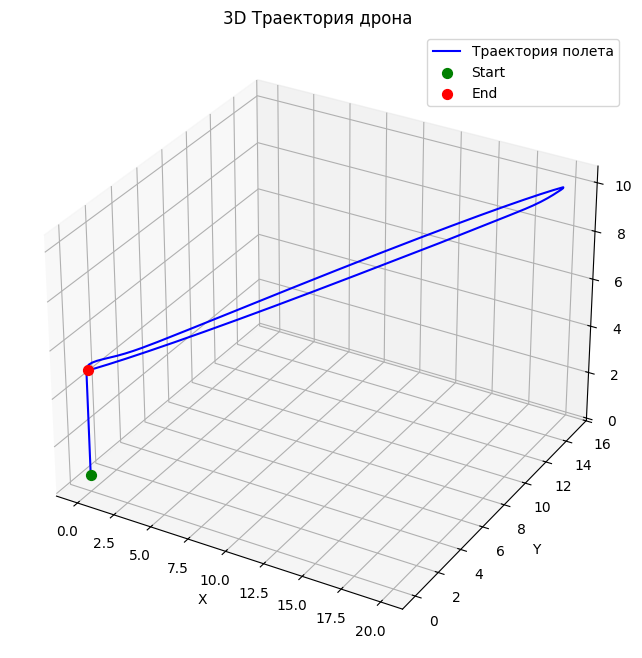

In [7]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# Строим траекторию
ax.plot(df["x"], df["y"], df["z"], label="Траектория полета", color="b")

# Обозначим старт и финиш
ax.scatter(
    df["x"].iloc[0],
    df["y"].iloc[0],
    df["z"].iloc[0],
    color="g",
    s=50,
    label="Start",
)
ax.scatter(
    df["x"].iloc[-1],
    df["y"].iloc[-1],
    df["z"].iloc[-1],
    color="r",
    s=50,
    label="End",
)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.title("3D Траектория дрона")
plt.show()

Построим график изменения модуля скорости во времени

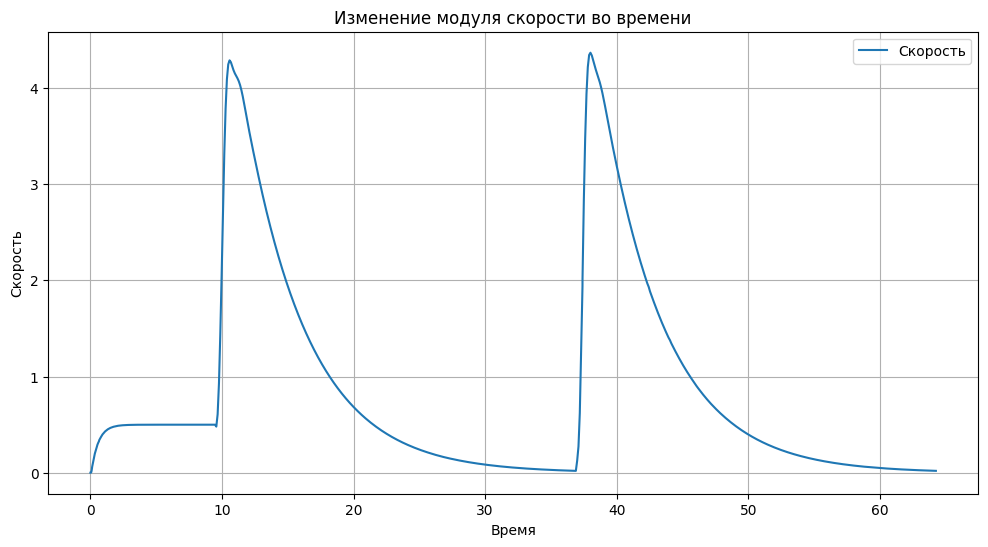

In [8]:
df["v"] = np.sqrt(df["vx"] ** 2 + df["vy"] ** 2 + df["vz"] ** 2)

plt.figure(figsize=(12, 6))
plt.plot(df["timestamp"], df["v"], label="Скорость")
plt.xlabel("Время")
plt.ylabel("Скорость")
plt.title("Изменение модуля скорости во времени")
plt.grid(True)
plt.legend()
plt.show()

Теперь давайте добавим в значения скорости шум и еще раз посмотрим на график

In [9]:
# Генерируем нормальный шум (среднее 0, станд. отклонение 0.5)
noise = np.random.normal(0, 0.5, size=len(df))

# Добавляем шум к идеальной скорости
df["v_noisy"] = df["v"] + noise

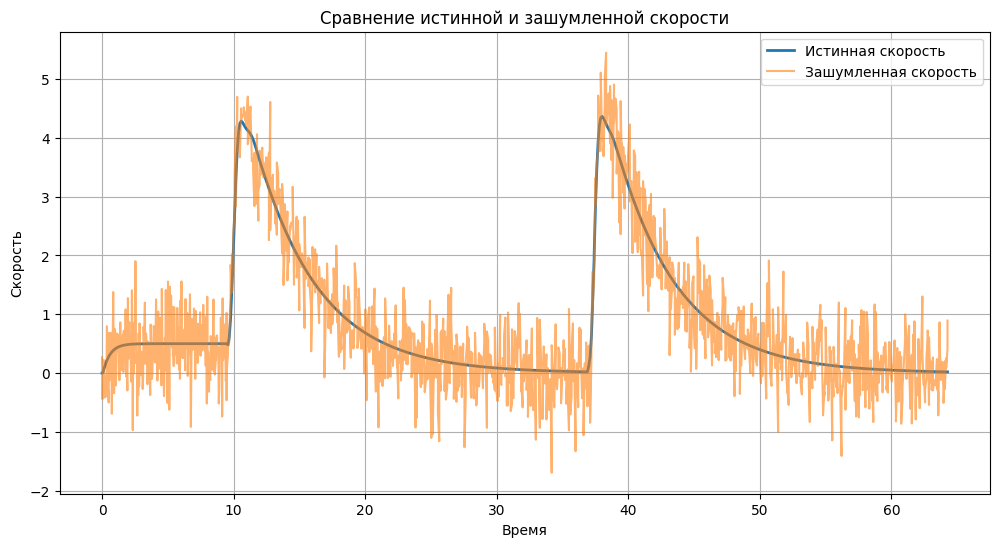

In [10]:
plt.figure(figsize=(12, 6))

plt.plot(df["timestamp"], df["v"], label="Истинная скорость", linewidth=2)
plt.plot(
    df["timestamp"], df["v_noisy"], label="Зашумленная скорость", alpha=0.6
)

plt.xlabel("Время")
plt.ylabel("Скорость")
plt.title("Сравнение истинной и зашумленной скорости")
plt.grid(True)
plt.legend()
plt.show()